# Example notebook for groupwise registration using GreedyFHist

### Step 1: Loading image data

GreedyFHist has some utility functions for load image data, but ultimately the only requirement is that image data can be converted to a `numpy.array`.

In [1]:
import matplotlib.pyplot as plt

from greedyfhist.data_types import OMETIFFImage
from greedyfhist.registration import GreedyFHist
from greedyfhist.options import RegistrationOptions

In [2]:
image_path1 = '../groupwise_examples/hes.tif'
image_path2 = '../groupwise_examples/mts.tif'
image_path3 = '../groupwise_examples/ihc.tif'

In [3]:
image1 = OMETIFFImage.load_from_path(image_path1)
image2 = OMETIFFImage.load_from_path(image_path2)
image3 = OMETIFFImage.load_from_path(image_path3)

Text(0.5, 1.0, 'IHC')

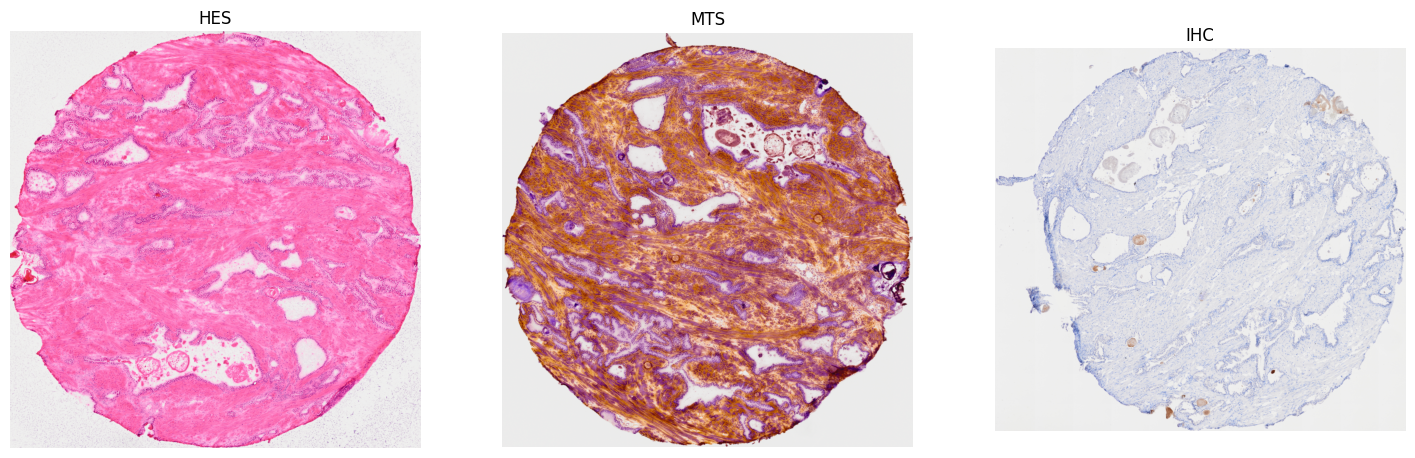

In [4]:
fig, axs = plt.subplots(1, 3, figsize=(18, 6))
for ax in axs:
    ax.axis('off')
axs[0].imshow(image1.data)
axs[0].set_title('HES')
axs[1].imshow(image2.data)
axs[1].set_title('MTS')
axs[2].imshow(image3.data)
axs[2].set_title('IHC')

### Step 2: Groupwise Registration

For the groupwise registration an ordered list of images needs be used. The result is a groupwise_registration_result which contains affine and nonrigid transformations from all moving image spaces to fixed image spaces.

In [5]:
options = RegistrationOptions()
options.nonrigid_registration_options.resolution = (1024, 1024)
registerer = GreedyFHist.load_from_config()

In [6]:
# For groupwise registration we need to extract an ordered list of images.
# This list can either be a list of images or a list of tuple of shape (image, mask).

img_list = [image1.data, image2.data, image3.data]

In [7]:
groupwise_registration_result, _ = registerer.groupwise_registration(img_list)

After groupwise registration, we receive an object of type GroupwiseRegistrationResult that contains a pairwise list of affine registrations and nonrigid registrations between affinely transformed moving images and the fixed image.

In [8]:
# For getting the registration of any moving to the fixed image we can use the get_transforms method.
# image1_to_image3_transform and image2_to_image3_transform can be used the same way as transformations from the pairwise transform.

image1_to_image3_transform = groupwise_registration_result.get_transforms(0)
image2_to_image3_transform = groupwise_registration_result.get_transforms(1)

### Step 3: Transform to fixed image spaces.

In [9]:
warped_image1 = registerer.transform_image(image1.data, image1_to_image3_transform.forward_transform, 'LINEAR')
warped_image2 = registerer.transform_image(image2.data, image2_to_image3_transform.forward_transform, 'LINEAR')

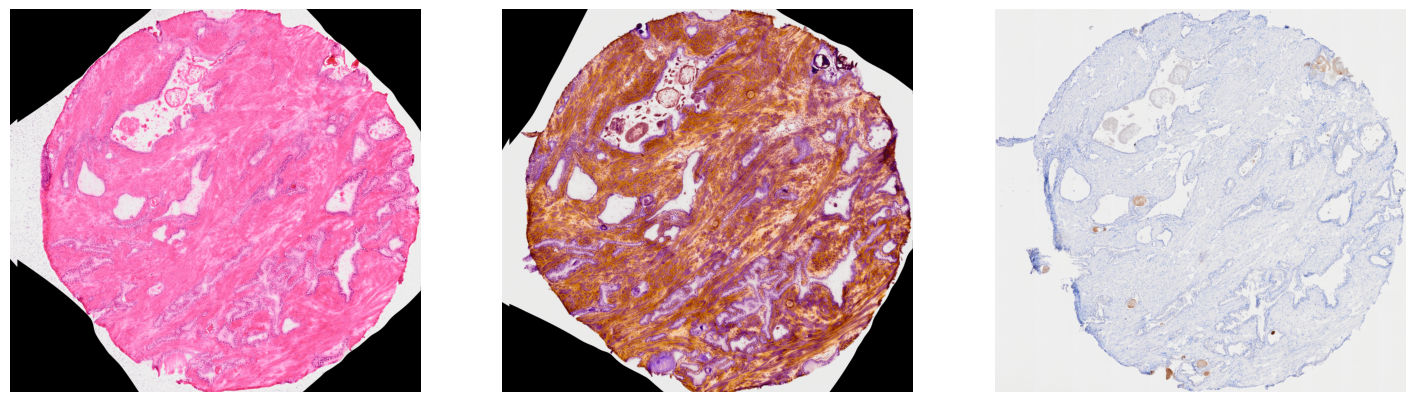

In [10]:
fig, axs = plt.subplots(1, 3, figsize=(18, 6))
for ax in axs:
    ax.axis('off')
axs[0].imshow(warped_image1)
axs[1].imshow(warped_image2)
axs[2].imshow(image3.data)

In [11]:
image3_to_image1_transform = groupwise_registration_result.get_transforms(2, 0)
image2_to_image1_transform = groupwise_registration_result.get_transforms(1, 0)

In [12]:
rev_warped_image3 = registerer.transform_image(image3.data, image3_to_image1_transform.forward_transform, 'LINEAR')
rev_warped_image2 = registerer.transform_image(image2.data, image2_to_image1_transform.forward_transform, 'LINEAR')

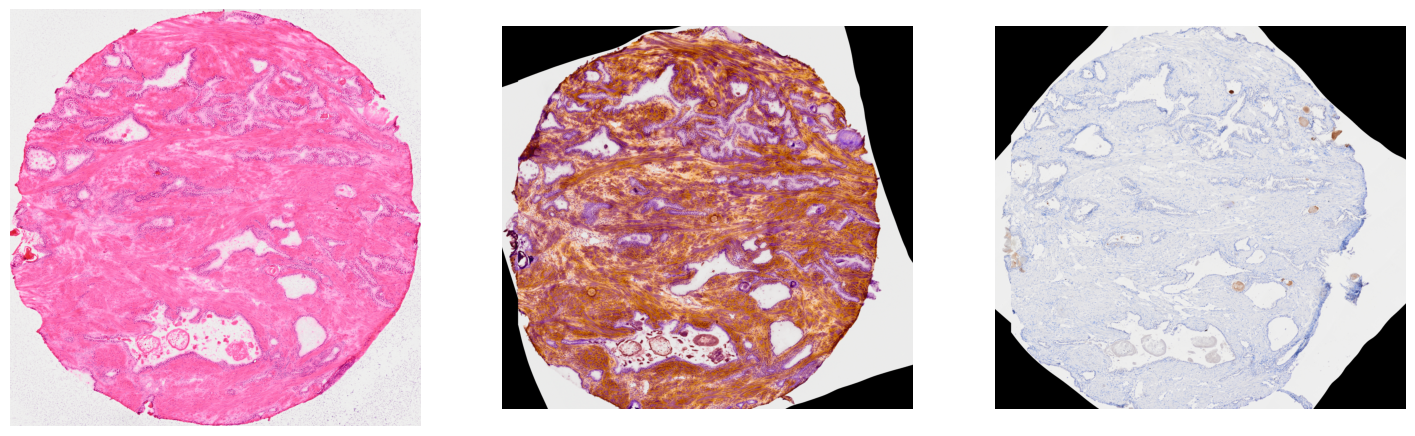

In [13]:
fig, axs = plt.subplots(1, 3, figsize=(18, 6))
for ax in axs:
    ax.axis('off')
axs[0].imshow(image1.data)
axs[1].imshow(rev_warped_image2)
axs[2].imshow(rev_warped_image3)

In [14]:
from greedyfhist.registration.greedy_f_hist import compose_transforms, RegistrationTransforms

In [15]:
transforms = []
transforms.append(groupwise_registration_result.reverse_affine_transform[1])
transforms.append(groupwise_registration_result.reverse_affine_transform[0])
transforms.append(groupwise_registration_result.reverse_deformable_transform[0])


composited_forward_transform = compose_transforms([x.forward_transform for x in transforms])
composited_backward_transform = compose_transforms([x.backward_transform for x in transforms][::-1])
reg_result = RegistrationTransforms(composited_forward_transform, composited_backward_transform)

In [16]:
rev_warped_image3 = registerer.transform_image(image3.data, reg_result.forward_transform, 'LINEAR')

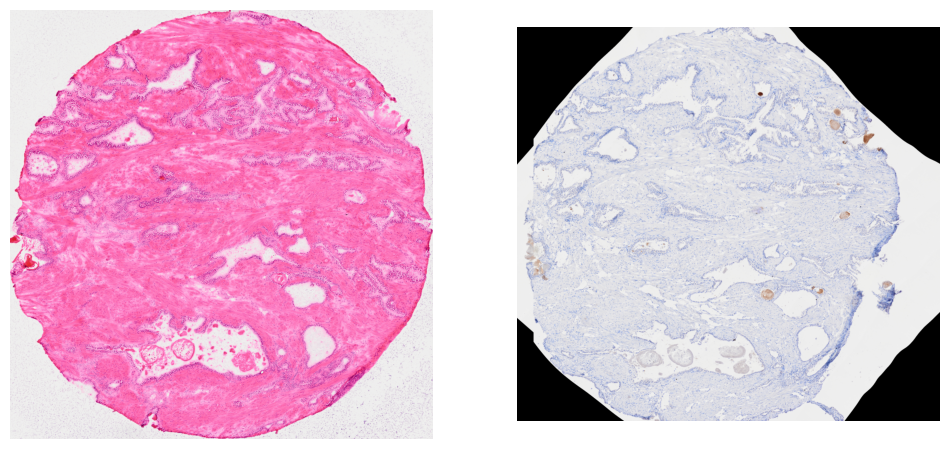

In [17]:
fig, axs = plt.subplots(1, 2, figsize=(12, 6))
for ax in axs:
    ax.axis('off')
axs[0].imshow(image1.data)
axs[1].imshow(rev_warped_image3)

In [12]:
groupwise_registration_result.reverse_deformable_transform

[RegistrationTransforms(forward_transform=GFHTransform(size=(2857, 3064), transform=<SimpleITK.SimpleITK.CompositeTransform; proxy of <Swig Object of type 'itk::simple::CompositeTransform *' at 0x7f4a9e8e0570> >), backward_transform=GFHTransform(size=(2857, 3064), transform=<SimpleITK.SimpleITK.CompositeTransform; proxy of <Swig Object of type 'itk::simple::CompositeTransform *' at 0x7f4a9e8e0cc0> >), cmdln_returns=[CompletedProcess(args=['greedy', '-d', '2', '-m', 'ncc', '10x10', '-i', 'tmp/0/nr_fixed_preprocessing/preprocessed/new_small_image.nii.gz', 'tmp/0/nr_moving_preprocessing/preprocessed/new_small_image.nii.gz', '-n', '100x100x50x10', '-threads', '1', '-s', '5.0vox', '5.0vox', '-o', 'tmp/0/output/registrations/0/metrics/small_resolution/small_warp.nii.gz', '-oinv', 'tmp/0/output/registrations/0/metrics/small_resolution/small_inv_warp.nii.gz', '-ia', 'tmp/0/Affine_init.mat'], returncode=0, stdout=b'Limiting the number of threads to 1\nNoise on image 0 component 0: fixed = 0.238

In [13]:
groupwise_registration_result.get_transforms(0, 2)

IndexError: list index out of range

In [12]:
source = 2
target = 0
if source < target:
    strt_idx = source
    stp_idx = target
    reverse = False
else:
    strt_idx = target
    stp_idx = source
    reverse = True
strt_idx, stp_idx

(0, 2)

In [16]:
groupwise_registration_result.reverse_affine_transform[strt_idx:stp_idx]

[RegistrationTransforms(forward_transform=GFHTransform(size=(2917, 2873), transform=<SimpleITK.SimpleITK.CompositeTransform; proxy of <Swig Object of type 'itk::simple::CompositeTransform *' at 0x7f4a9f143e70> >), backward_transform=GFHTransform(size=(3010, 2983), transform=<SimpleITK.SimpleITK.CompositeTransform; proxy of <Swig Object of type 'itk::simple::CompositeTransform *' at 0x7f4a9f176240> >), cmdln_returns=[CompletedProcess(args=['greedy', '-d', '2', '-i', 'tmp/0/affine_fixed_preprocessing/preprocessed/new_small_image.nii.gz', 'tmp/0/affine_moving_preprocessing/preprocessed/new_small_image.nii.gz', '-o', 'tmp/0/output/registrations/0/metrics/small_resolution/small_affine.mat', '-m', 'ncc', '10x10', '-n', '100x50x10', '-threads', '1', '-dof', '12', '-search', '10000', '180', '106', '-gm-trim', '10x10', '-a', '-ia', 'tmp/0/Affine_init.mat'], returncode=0, stdout=b'Limiting the number of threads to 1\nNoise on image 0 component 0: fixed = 0.228304, moving = 0.229595\nRigid search

In [17]:
groupwise_registration_result.reverse_deformable_transform[stp_idx]

IndexError: list index out of range

In [13]:
list(range(2, 0, -1))

[2, 1]

In [14]:
list(range(0, 2))

[0, 1]

In [14]:
strt_idx = 2
stp_idx = 0

groupwise_registration_result.reverse_deformable_transform[stp_idx]

RegistrationTransforms(forward_transform=GFHTransform(size=(2857, 3064), transform=<SimpleITK.SimpleITK.CompositeTransform; proxy of <Swig Object of type 'itk::simple::CompositeTransform *' at 0x7f4a9e8e0570> >), backward_transform=GFHTransform(size=(2857, 3064), transform=<SimpleITK.SimpleITK.CompositeTransform; proxy of <Swig Object of type 'itk::simple::CompositeTransform *' at 0x7f4a9e8e0cc0> >), cmdln_returns=[CompletedProcess(args=['greedy', '-d', '2', '-m', 'ncc', '10x10', '-i', 'tmp/0/nr_fixed_preprocessing/preprocessed/new_small_image.nii.gz', 'tmp/0/nr_moving_preprocessing/preprocessed/new_small_image.nii.gz', '-n', '100x100x50x10', '-threads', '1', '-s', '5.0vox', '5.0vox', '-o', 'tmp/0/output/registrations/0/metrics/small_resolution/small_warp.nii.gz', '-oinv', 'tmp/0/output/registrations/0/metrics/small_resolution/small_inv_warp.nii.gz', '-ia', 'tmp/0/Affine_init.mat'], returncode=0, stdout=b'Limiting the number of threads to 1\nNoise on image 0 component 0: fixed = 0.2389